In [217]:
!pip install autograd
!pip install scikit-plot
!pip install seaborn


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   - -------------------------------------- 10.2/294.9 kB ? eta -:--:--
   --------------- ------------------------ 112.6/294.9 kB 1.7 MB/s eta 0:00:01
   ---------------------------------------- 294.9/294.9 kB 3.0 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# importing libraries
import autograd.numpy as np 
from autograd import grad, elementwise_grad
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import pandas as pd
import seaborn as sns
from sklearn.datasets import load_digits, load_breast_cancer
%matplotlib inline
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.preprocessing import LabelEncoder, label_binarize, PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, RocCurveDisplay, mean_squared_error
import string

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, RegressorMixin  # not actuall anymore
from sklearn.utils import resample
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

### part A

In [ ]:
### Hardcoded Values
traintestrat = 0.2    # train-test split ratio
figpath = 'C:\DATA_ANALYSIS_TEST\Proj2_Figs'

In [80]:
# defining activation functions:

def ReLU(z):
    return np.where(z > 0, z, 0)

def ReLU_leaky(z, alpha=0.01):
    return np.where(z > 0, z, alpha * z)

def ReLU_der(z):
    return np.where(z > 0, 1, 0)

def ReLU_leaky_der(z, alpha=0.01):
    return np.where(z > 0, 1, alpha)

def linear(z):
    return z

def linear_der(z):
    return np.ones_like(z)

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def softmax(z):
    """Compute softmax values for each set of scores in the rows of the matrix z.
    Used with batched input data."""
    e_z = np.exp(z - np.max(z, axis=0))
    return e_z / np.sum(e_z, axis=1)[:, np.newaxis]

def softmax_stable(z):
    '''
    avoiding overflow by subtracting the maximum logit per sample before exponentiating 
    '''
    z_stable = z - np.max(z, axis=1, keepdims=True)
    e_z = np.exp(z_stable)
    return e_z / np.sum(e_z, axis=1, keepdims=True)

def softmax_vec(z):
    """Compute softmax values for each set of scores in the vector z.
    Use this function when you use the activation function on one vector at a time"""
    e_z = np.exp(z - np.max(z))
    return e_z / np.sum(e_z)

def sigmoid_der(z):
    return sigmoid(z)*(1-sigmoid(z))

def mse(predict, target, weights=None, regularization=None, lambdaVal=0.0):
    """
    Mean Squared Error loss with optional L1/L2 regularization.
    """
    base_loss = np.mean((predict - target) ** 2)
    if regularization == 'L2' and weights is not None:
        reg_term = lambdaVal * np.sum(weights ** 2)
        return base_loss + reg_term
    elif regularization == 'L1' and weights is not None:
        reg_term = lambdaVal * np.sum(np.abs(weights))
        return base_loss + reg_term
    return base_loss

def mse_der(predict, target):
    """
    Derivative of MSE with optional L1/L2 regularization.
    No regularization here (as its relevant for dCdw only, but there we make it an add-on in Backpropagation function)
    """
    return 2 * (predict - target) / predict.shape[0]

def accuracy(predictions, targets):
    """
    Compute classification accuracy (one-hot targets).
    """
    pred_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(targets, axis=1)
    return np.mean(pred_classes == true_classes)

def cross_entropy(predict, target, weights=None, regularization=None, lambdaVal=0.0):
    """
    Cross-entropy loss with optional L1/L2 regularization.
    """
    epsilon = 1e-12
    predict = np.clip(predict, epsilon, 1. - epsilon)
    base_loss = -np.sum(target * np.log(predict)) / predict.shape[0]
    if regularization == 'L2' and weights is not None:
        base_loss += lambdaVal * np.sum(weights ** 2)
    elif regularization == 'L1' and weights is not None:
        base_loss += lambdaVal * np.sum(np.abs(weights))
    return base_loss

def cross_entropy_der(predict, target):
    """
    Derivative for softmax + cross-entropy combination
    Regularization effect is inside the backpropagation function as a seperate add-on
    """
    return (predict - target) / predict.shape[0]

In [81]:
def BATCH_feed_forward(input, layers, activation_funcs):
    a = input
    for (W, b), activation_func in zip(layers, activation_funcs):
        z = a@W+b                     # flipped a, W
        a = activation_func(z)
    return a

def BATCH_feed_forward_saver(input, layers, activation_funcs):
    '''
    modification: because backprop needs a save of all FeedForward calculations (z) to be used later for the sigmas 
    '''
    layer_inputs = []
    zs = []
    a = input
    for (W, b), activation_func in zip(layers, activation_funcs):
        layer_inputs.append(a)
        z = a@W + b    #flipped a, W
        a = activation_func(z)
        zs.append(z)
    return layer_inputs, zs, a

def BATCH_cost(layers, input, activation_funcs, target, cost_type='entropy', regularization=None, lambdaVal=0.0):
    predict = BATCH_feed_forward(input, layers, activation_funcs)
    if cost_type == 'entropy':
        return cross_entropy(predict, target, weights=np.concatenate([W.flatten() for W, _ in layers]), regularization=regularization,lambdaVal=lambdaVal)
    elif cost_type == 'mse':
        return mse(predict, target, weights=np.concatenate([W.flatten() for W, _ in layers]), regularization=regularization, lambdaVal=lambdaVal)
    
def BATCH_backpropagation(input, layers, activation_funcs, target, activation_ders, cost_der=cross_entropy_der, regularization=None, lambdaVal=0.0):
    """
    Batched backpropagation with L1/L2 regularization mod.
    """
    layer_inputs, zs, predict = BATCH_feed_forward_saver(input, layers, activation_funcs)
    layer_grads = [() for layer in layers]
    # We loop over the layers, from the last to the first
    dC_dz_next = None  # Store gradient from next (up-lvl) layer
    for i in reversed(range(len(layers))):
        W, b = layers[i]  #current layer
        layer_input, z, activation_der_func = layer_inputs[i], zs[i], activation_ders[i]
        activation_der_values = activation_der_func(z)
        if i == len(layers) - 1:
            # For last layer: dC_dz = cost_der*activation_der_values
            # dC_da = cost_der(predict, target)
            # dC_dz = dC_da*activation_der_values
            if cost_der == cross_entropy_der:
                dC_dz = cost_der(predict, target)  #this is a combo for cross entropy and softmax!!!
            elif cost_der == mse_der:
                dC_da = cost_der(predict, target)
                dC_dz = dC_da*activation_der_values
        else:
            # For hidden layers: (inheritance) @ (up-lvel W) * (new activation derivative)
            # change for batched input!
            # dC_dz = dC_dz_next@W_next.T  * activation_der_values
            W_next, b_next = layers[i + 1] #downstream layer
            dC_da = dC_dz_next@W_next.T
            dC_dz = dC_da * activation_der_values
        # Compute gradients for this layer
        dC_dW = layer_input.T@dC_dz # changed for batched input
        dC_db = np.sum(dC_dz, axis=0) # changed to sum over batches
        # Regularization Add-on (using current layer W!)
        if regularization == 'L2':
            dC_dW += 2*lambdaVal*W
        elif regularization == 'L1':
            dC_dW += lambdaVal*np.sign(W)
        # Store this lvl 
        dC_dz_next = dC_dz
        layer_grads[i] = (dC_dW, dC_db)
    return layer_grads

In [82]:
class yagdi_NN:
    '''
    Yet Another Gradient Descent Index for Neural Networks
    '''
    def __init__(self, ProblemType='classification', learning_rate=0.01, optimizer='vanillagd', regularization=None, lambdaVal=0.0, max_iter=1000, max_epoch=100, tol=1e-6, momentum=0.9, beta1=0.9, beta2=0.999, epsilon=1e-8, batch_type='batch', batch_size=32):
        self.problem_type = ProblemType
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.tol = tol
        self.max_epoch = max_epoch
        self.optimizer = optimizer
        self.regularization = regularization
        self.lambdaVal = lambdaVal
        self.momentum = momentum
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.batch_type = batch_type
        self.batch_size = batch_size

        # Initialize state
        self.velocity_W = None
        self.velocity_b = None
        self.G_W = None
        self.G_b = None
        self.G2_W = None
        self.G2_b = None
        self.G3_W = None
        self.G3_b = None
        self.G4_W = None
        self.G4_b = None
        self.t = 0
    
    def initialize_for_layers(self, layers):
        '''
        Initialize optimizer state for the given layers
        '''
        self.velocity_W = [np.zeros_like(W) for W, b in layers]
        self.velocity_b = [np.zeros_like(b) for W, b in layers]
        self.G_W = [np.zeros_like(W) for W, b in layers]
        self.G_b = [np.zeros_like(b) for W, b in layers]
        self.G2_W = [np.zeros_like(W) for W, b in layers]
        self.G2_b = [np.zeros_like(b) for W, b in layers]
        self.G3_W = [np.zeros_like(W) for W, b in layers]
        self.G3_b = [np.zeros_like(b) for W, b in layers]
        self.G4_W = [np.zeros_like(W) for W, b in layers]
        self.G4_b = [np.zeros_like(b) for W, b in layers]
        self.t = 0
    
    def _get_batch(self, X, y):
        '''
        Select 1 random batch based on batch_type
        '''
        n_samples = X.shape[0]

        if self.batch_type == 'batch':
            return X, y  # Full dataset
        elif self.batch_type == 'stochastic':
            # Single random sample
            idx = np.random.randint(n_samples)
            return X[idx:idx+1], y[idx:idx+1]
        elif self.batch_type == 'minibatch':
            # ONE random mini-batch
            batch_size = min(self.batch_size, n_samples)
            indices = np.random.choice(n_samples, batch_size, replace=False)
            return X[indices], y[indices]
    
    def fit(self, X, y, layers, activation_funcs, activation_ders):
        '''
        Main training method - uses backpropagation internally
        compared to proj1, only 1 batch is evaluated er epoch 
        '''
        # Initialize optimizer variables ONCE
        self.initialize_for_layers(layers)
        
        total_iterations = 0
        converged = False
        
        # EPOCH LOOP 
        for epoch in range(self.max_epoch):
            if total_iterations >= self.max_iter:
                break
            if converged:
                break
            
            # Get ONE random batch per epoch
            X_batch, y_batch = self._get_batch(X, y)
            
            # Compute gradients using backpropagation
            if self.problem_type=='classification':
                gradients = BATCH_backpropagation(X_batch, layers, activation_funcs, y_batch, activation_ders, cost_der=cross_entropy_der, regularization=self.regularization, lambdaVal=self.lambdaVal)
            elif self.problem_type=='regression':
                gradients = BATCH_backpropagation(X_batch, layers, activation_funcs, y_batch, activation_ders, cost_der=mse_der, regularization=self.regularization, lambdaVal=self.lambdaVal)
            else:
                raise ValueError(f"Unknown problem type: {self.type}")
            
            # Apply optimizer update
            layers = self._apply_optimizer_update(layers, gradients)
            total_iterations += 1

            grad_norm = self._compute_gradient_norm(gradients)
            if grad_norm < self.tol:
                converged = True
                break

        return layers

    def _compute_gradient_norm(self, gradients):
        '''
        Compute norm of all gradients for convergence check
        '''
        total_norm = 0
        for dW, db in gradients:
            total_norm += np.sum(dW**2) + np.sum(db**2)
        return np.sqrt(total_norm)
    
    def _apply_optimizer_update(self, layers, gradients):
        '''
        Layer GD updates
        Note: with regularization inside gradients!
        '''
        updated_layers = []
        for layer_idx, ((W, b), (dW, db)) in enumerate(zip(layers, gradients)):

            if self.optimizer == 'vanillagd':
                W_new = W - self.learning_rate * dW
                b_new = b - self.learning_rate * db
                
            elif self.optimizer == 'momentum':
                self.velocity_W[layer_idx] = self.momentum * self.velocity_W[layer_idx] - self.learning_rate * dW
                self.velocity_b[layer_idx] = self.momentum * self.velocity_b[layer_idx] - self.learning_rate * db
                
                W_new = W + self.velocity_W[layer_idx]
                b_new = b + self.velocity_b[layer_idx]
                
            elif self.optimizer == 'adagrad':
                self.G_W[layer_idx] += dW**2
                self.G_b[layer_idx] += db**2
                
                lr_W = self.learning_rate / (np.sqrt(self.G_W[layer_idx]) + self.epsilon)
                lr_b = self.learning_rate / (np.sqrt(self.G_b[layer_idx]) + self.epsilon)
                
                W_new = W - lr_W * dW
                b_new = b - lr_b * db
                
            elif self.optimizer == 'rmsprop':
                self.G2_W[layer_idx] = self.beta1 * self.G2_W[layer_idx] + (1 - self.beta1) * dW**2
                self.G2_b[layer_idx] = self.beta1 * self.G2_b[layer_idx] + (1 - self.beta1) * db**2
                
                lr_W = self.learning_rate / (np.sqrt(self.G2_W[layer_idx]) + self.epsilon)
                lr_b = self.learning_rate / (np.sqrt(self.G2_b[layer_idx]) + self.epsilon)
                
                W_new = W - lr_W * dW
                b_new = b - lr_b * db
                
            elif self.optimizer == 'adam':
                self.t += 1
                
                # First moment
                self.G3_W[layer_idx] = self.beta1 * self.G3_W[layer_idx] + (1 - self.beta1) * dW
                self.G3_b[layer_idx] = self.beta1 * self.G3_b[layer_idx] + (1 - self.beta1) * db
                
                # Second moment
                self.G4_W[layer_idx] = self.beta2 * self.G4_W[layer_idx] + (1 - self.beta2) * dW**2
                self.G4_b[layer_idx] = self.beta2 * self.G4_b[layer_idx] + (1 - self.beta2) * db**2
                
                # Bias correction
                m_W_hat = self.G3_W[layer_idx] / (1 - self.beta1**self.t)
                m_b_hat = self.G3_b[layer_idx] / (1 - self.beta1**self.t)
                v_W_hat = self.G4_W[layer_idx] / (1 - self.beta2**self.t)
                v_b_hat = self.G4_b[layer_idx] / (1 - self.beta2**self.t)
                
                # Update
                W_new = W - self.learning_rate * m_W_hat / (np.sqrt(v_W_hat) + self.epsilon)
                b_new = b - self.learning_rate * m_b_hat / (np.sqrt(v_b_hat) + self.epsilon)
            
            else:
                # Fallback to vanilla GD
                W_new = W - self.learning_rate * dW
                b_new = b - self.learning_rate * db
            
            updated_layers.append((W_new, b_new))
        
        return updated_layers 

In [ ]:
class YANNI:
    def __init__(self, ProblemType='classification', network_architecture=None, activation_funcs=None, optimizer='adam', batch_type='minibatch', regularization=None, learning_rate=0.01, batch_size=32, lambdaVal=0.0, max_iter=1000, max_epoch=100, tol=1e-6, momentum=0.9, beta1=0.9, beta2=0.999, epsilon=1e-8):
        '''
        Yet Another Neural Network Index
        - Network architecture setup
        - Forward propagation  
        - Training in yagdi_NN optimizer (handles backpropagation internally)

        Paramters: 
            problem type: regression or classification, forwards the info to yagdi_NN (where it will mean mse or cross entropy)
            network_architecture: Layer sizes [input_size, hidden1_size, hidden2_size, ..., output_size]
            activation_funcs: list of function names (derivatives are mapped inside, just make sure the function are pre-defined)
            learning_rate, batch_size, max_iter, max_epoch, tol (defaults) for yagdi_NN
            provide: optimizer('adam', 'vanillagd', 'rmsprop', 'momentum'), batch_type('minibatch', 'stochastic', 'batch') and regularization('L2', 'L1')
            regulariation option unavailable
        '''
        self.ProblemType = ProblemType.lower()
        self.network_architecture = network_architecture
        self.activation_funcs = activation_funcs
        self.activation_ders = self._get_activation_derivatives(activation_funcs)
        
        # Initialize layers
        self.layers = self._create_layers(network_architecture)
        
        # Initialize optimizer (yagdi_NN handles backpropagation internally)
        self.optimizer = yagdi_NN(
            ProblemType=self.ProblemType,
            regularization=regularization,
            learning_rate=learning_rate,
            lambdaVal=lambdaVal,
            optimizer=optimizer,
            max_iter=max_iter,
            max_epoch=max_epoch,
            tol=tol,
            batch_type=batch_type,
            batch_size=batch_size,
            momentum=momentum,
            beta1=beta1,
            beta2=beta2,
            epsilon=epsilon
        )

    def _to_onehot(self, y, n_classes=None):
        """Convert class labels to one-hot encoding"""
        if n_classes is None:
            n_classes = len(np.unique(y))
        return np.eye(n_classes)[y]
    
    def _create_layers(self, architecture):
        """Create network layers"""
        layers = []
        for i in range(len(architecture) - 1):
            input_size = architecture[i]
            output_size = architecture[i + 1]
            W = np.random.randn(input_size, output_size) * np.sqrt(2 / input_size)
            b = np.random.randn(output_size) * np.sqrt(2 / input_size)
            layers.append((W, b))
        return layers
    
    def _get_activation_derivatives(self, activation_funcs):
        """Map activation functions to their derivatives"""
        derivative_map = {
            sigmoid: sigmoid_der,
            ReLU: ReLU_der,
            ReLU_leaky: ReLU_leaky_der,
            softmax_stable: lambda x: 1,  
            softmax: lambda x: 1,  
            linear: linear_der
            # tanh: tanh_der
        }
        return [derivative_map[func] for func in activation_funcs]
    
    def forward_propagation(self, X):
        """Forward pass through the network"""
        return BATCH_feed_forward(X, self.layers, self.activation_funcs)
    
    def compute_cost(self, X, y):
        """Compute cost on given data"""
        if self.ProblemType == 'regression':
            return BATCH_cost(layers=self.layers, input=X, activation_funcs=self.activation_funcs, target=y, cost_type='mse', regularization=self.optimizer.regularization, lambdaVal=self.optimizer.lambdaVal)
        elif self.ProblemType == 'classification':
            return BATCH_cost(layers=self.layers, input=X, activation_funcs=self.activation_funcs, target=y, cost_type='entropy', regularization=self.optimizer.regularization, lambdaVal=self.optimizer.lambdaVal)
    
    def compute_accuracy(self, X, y):
        """Compute accuracy on given data"""
        predictions = self.forward_propagation(X)
        predicted_classes = np.argmax(predictions, axis=1)

        # Handle both one-hot and class labels
        if y.ndim == 2 and y.shape[1] > 1:  # One-hot encoded
            true_classes = np.argmax(y, axis=1)
        else:  # Class labels (flatten to 1D array)
            true_classes = y.reshape(-1)
            
        return np.mean(predicted_classes == true_classes)
    
    def train(self, X_train, y_train, X_val=None, y_val=None, verbose=True):
        """
        Complete training using yagdi_NN optimizer
        yagdi_NN handles backpropagation internally
        """
        if self.ProblemType == 'classification':
            # Convert to one-hot for training (works for both formats)
            if y_train.ndim == 1:  # Class labels
                y_train_onehot = self._to_onehot(y_train, n_classes=self.network_architecture[-1])
            else:  # Already one-hot
                y_train_onehot = y_train
        elif self.ProblemType == 'regression':
            y_train_onehot = y_train

        # Train using yagdi_NN (which calls BATCH_backpropagation internally)
        self.layers = self.optimizer.fit(
            X=X_train,
            y=y_train_onehot,
            layers=self.layers,
            activation_funcs=self.activation_funcs,
            activation_ders=self.activation_ders
        )
    
    def predict(self, X):
        """Make predictions on new data"""
        return self.forward_propagation(X)
    
    def predict_classes(self, X):
        """Return class predictions"""
        predictions = self.predict(X)
        return np.argmax(predictions, axis=1)
    
    def predict_proba(self, X):
        """Return probability predictions (compatible with sklearn)"""
        return self.forward_propagation(X)
    
    def _ensure_class_labels(self, y):
        """Convert any format to class labels - UNIVERSAL"""
        if y.ndim == 2 and y.shape[1] > 1:  # One-hot
            return np.argmax(y, axis=1)
        else:  # Class labels
            return y.reshape(-1)
    
    def plot_confusion_matrix(self, X, y_true, normalize='true'):
        """Plot confusion matrix - UNIVERSAL"""
        y_pred = self.predict_classes(X)
        y_true_classes = self._ensure_class_labels(y_true)
        
        disp = ConfusionMatrixDisplay.from_predictions(
            y_true_classes, y_pred,
            normalize=normalize,
            cmap=plt.cm.Blues,
            values_format='.2f'
        )
        plt.title('Normalized Confusion Matrix')
        plt.savefig(rf"{figpath}\{self.ProblemType}_ConfusionMatrix.png")
        plt.show()
    
    def plot_roc_curves(self, X, y_true):
        """Plot ROC curves - UNIVERSAL"""
        y_score = self.predict_proba(X)
        y_true_classes = self._ensure_class_labels(y_true)
        classes = np.unique(y_true_classes)
        n_classes = len(classes)
        
        # Binarize the labels for multiclass
        y_true_bin = label_binarize(y_true_classes, classes=classes)
        
        fig, ax = plt.subplots(figsize=(8, 6))

        if n_classes == 2:
            # For binary: y_true_bin has shape (n_samples,1), add the negative class
            y_true_bin = np.hstack([1 - y_true_bin, y_true_bin])

        for class_idx in range(n_classes):
            fpr, tpr, _ = roc_curve(y_true_bin[:, class_idx], y_score[:, class_idx])
            roc_auc = auc(fpr, tpr)
            display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, name=f'Class {classes[class_idx]} (AUC = {roc_auc:.2f})')
            display.plot(ax=ax)
        
        ax.plot([0, 1], [0, 1], 'k--', label='Random classifier')
        ax.legend()
        plt.title('ROC Curves')
        plt.grid(True)
        plt.savefig(rf"{figpath}\{self.ProblemType}_ROCcurve.png")
        plt.show()
    
    def plot_cumulative_gain(self, X, y_true):
        """Plot cumulative gain curves - UNIVERSAL"""
        y_score = self.predict_proba(X)
        y_true_classes = self._ensure_class_labels(y_true)
        classes = np.unique(y_true_classes)
        n_classes = len(classes)
        
        plt.figure(figsize=(8, 6))
        for class_idx in range(n_classes):
            y_true_binary = (y_true_classes == classes[class_idx]).astype(int)
            sort_idx = np.argsort(y_score[:, class_idx])[::-1]
            y_sorted = y_true_binary[sort_idx]
            
            # Handle case where there are no positive samples for this class
            if np.sum(y_sorted) > 0:
                cumulative_gains = np.cumsum(y_sorted) / np.sum(y_sorted)
            else:
                cumulative_gains = np.zeros_like(y_sorted, dtype=float)
                
            percentage_population = np.arange(1, len(y_sorted) + 1) / len(y_sorted)
            plt.plot(percentage_population, cumulative_gains, label=f'Class {classes[class_idx]}', lw=2)
        
        plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', lw=2)
        plt.xlabel('Percentage of Sample')
        plt.ylabel('Gain')
        plt.title('Cumulative Gain Curve')
        plt.legend(loc='lower right')
        plt.grid(True)
        plt.savefig(rf"{figpath}\{self.ProblemType}_CumGain.png")
        plt.show()
    
    def evaluate_model(self, X_test, y_test):
        """Run all evaluations at once - UNIVERSAL"""
        print("=== Model Evaluation ===")
        
        if self.ProblemType == 'classification':
            # Accuracy
            test_acc = self.compute_accuracy(X_test, y_test)
            print(f"Test Accuracy: {test_acc:.4f}")
            
            # Plots
            self.plot_confusion_matrix(X_test, y_test)
            self.plot_roc_curves(X_test, y_test)
            self.plot_cumulative_gain(X_test, y_test)
        
        elif self.ProblemType == 'regression':
            # MSE cost
            test_cost = self.compute_cost(X_test, y_test)
            print(f"Test Cost (MSE): {test_cost:.4f}")
            
            # Plot prediction vs true data
            plt.figure(figsize=(6, 6))
            y_pred = self.predict(X_test)
            plt.scatter(y_test, y_pred, alpha=0.7)
            plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
            plt.xlabel("True Values")
            plt.ylabel("Predictions")
            plt.title("Regression Predictions vs True Values")
            plt.grid(True)
            plt.show()

# CLASSIFICATION

### test: Iris Multiclassification

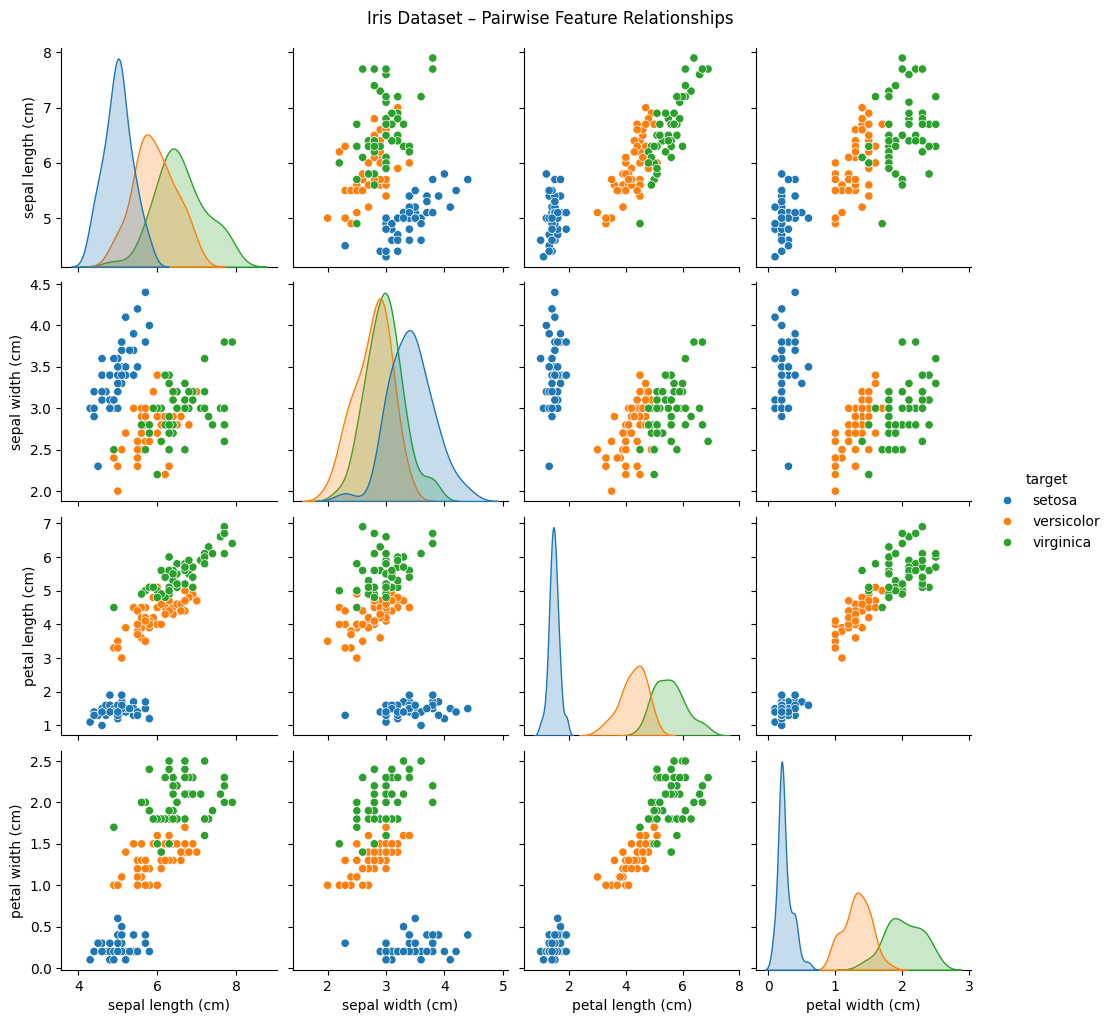

In [ ]:
iris = datasets.load_iris()
X_iris = iris.data  # Features
y_iris = iris.target # Target labels

iris_feature_names = iris.feature_names

df_iris = pd.DataFrame(X_iris, columns=iris_feature_names)
df_iris['target'] = pd.Series(y_iris).map({0: 'setosa', 1: 'versicolor', 2: 'virginica'})

sns.pairplot(df_iris[iris_feature_names + ['target']], hue='target')
plt.suptitle("Iris Dataset – Pairwise Feature Relationships", y=1.02)
plt.savefig(rf"{figpath}\Iris_pairplot.png")
plt.show()

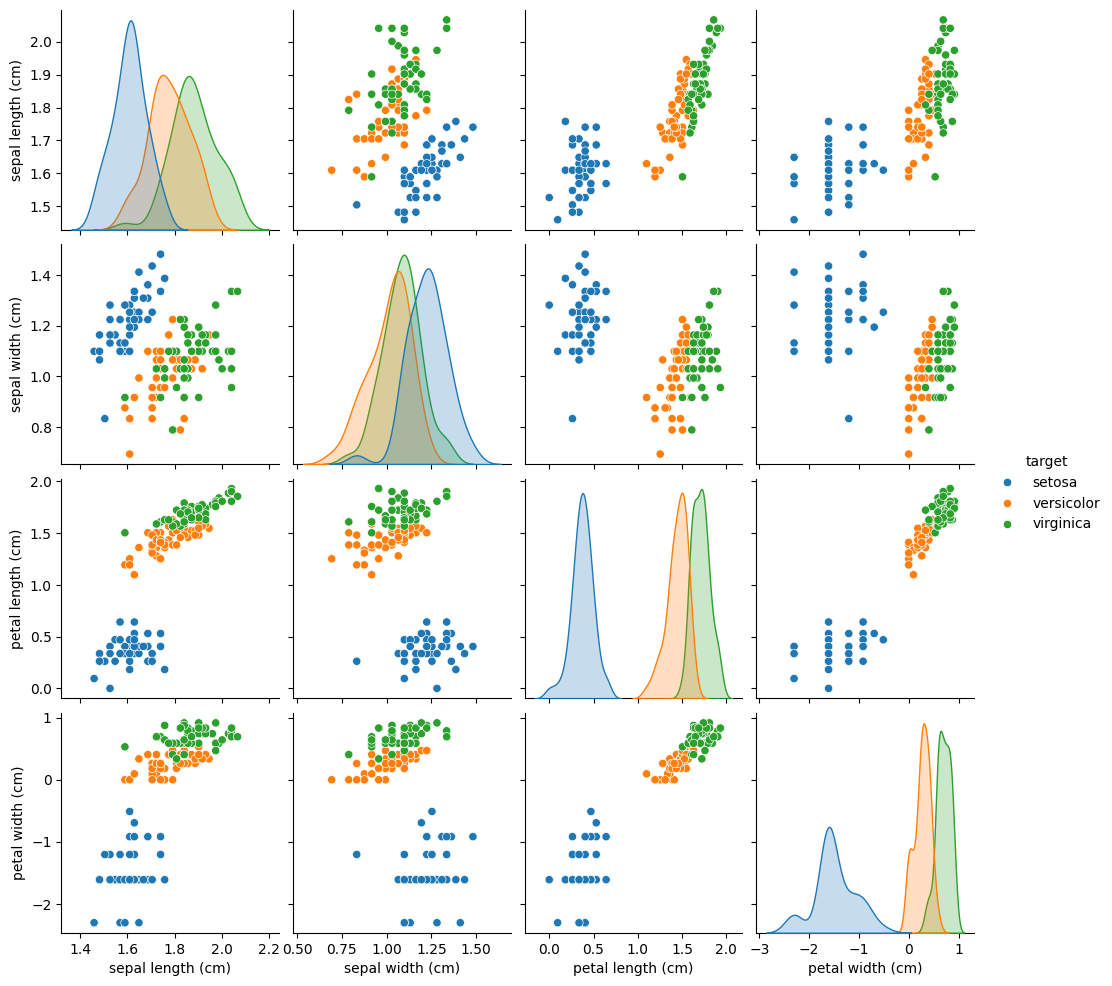

In [ ]:
# Log-transform ONLY numeric features
df_iris_log = df_iris.copy()
df_iris_log[iris_feature_names] = np.log(df_iris_log[iris_feature_names] + 1e-10)  # numeric only

# Target stays the same
df_iris_log['target'] = df_iris['target']

# Pairplot of log-transformed features
sns.pairplot(df_iris_log[iris_feature_names + ['target']], hue='target')
plt.savefig(rf"{figpath}\Iris_Log_pairplot.png")
plt.show()

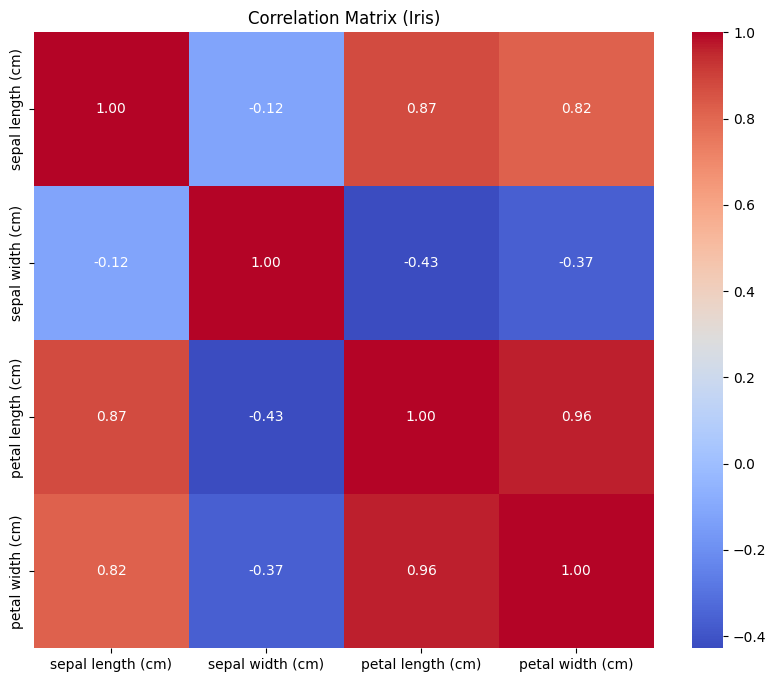

In [ ]:
corr_matrix_iris = df_iris[iris_feature_names].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix_iris, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix (Iris)")
plt.savefig(rf"{figpath}\Iris_CorrelationMatrix.png")
plt.show()

In [370]:
inputs = iris.data

# Since each prediction is a vector with a score for each of the three types of flowers,
# we need to make each target a vector with a 1 for the correct flower and a 0 for the others.
targets = np.zeros((len(iris.data), 3))
for i, t in enumerate(iris.target):
    targets[i, t] = 1

print(inputs.shape)
print(targets.shape)
# X_train, X_test, y_train, y_test = train_test_split(inputs, targets, test_size=0.2, random_state=42)

(150, 4)
(150, 3)


=== Model Evaluation ===
Test Accuracy: 0.9737


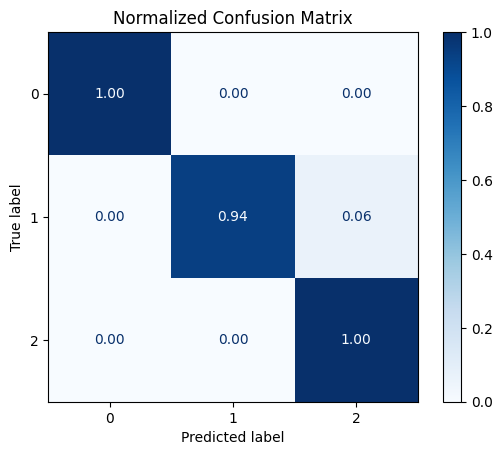

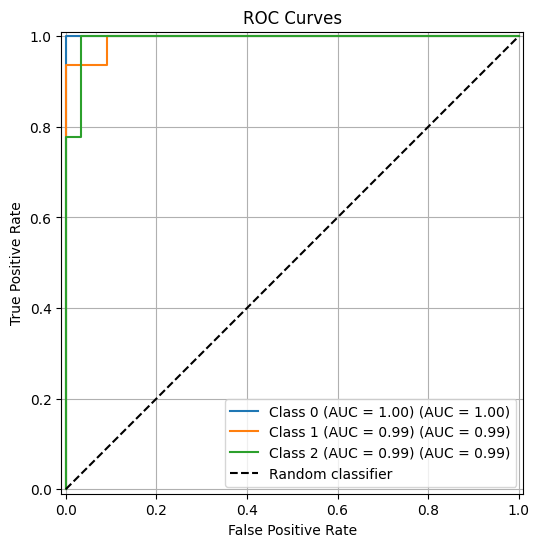

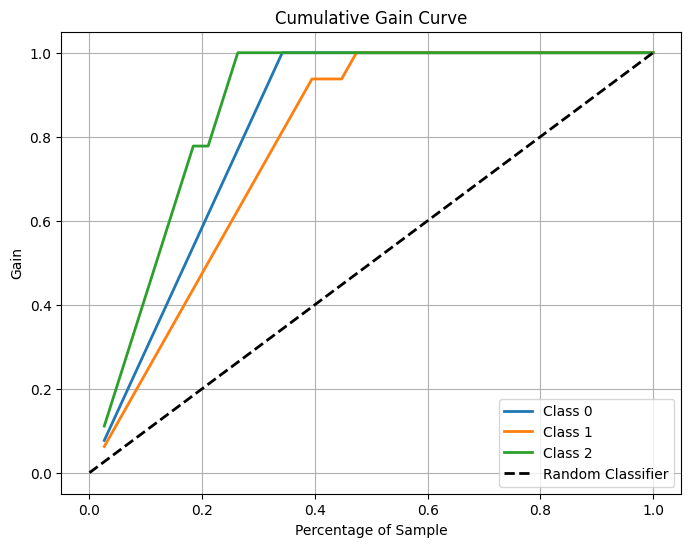

In [529]:
# X_iris = iris.data  # Features
# y_iris = iris.target # Target labels
# # Split into train/test
# X_train, X_test, y_train, y_test = train_test_split(X_iris,y_iris,random_state=0)

X_subset = df_iris[iris_feature_names].values  # numeric array
y_subset = y_iris  # binary target
X_train, X_test, y_train, y_test = train_test_split(X_subset, y_subset, random_state=0)


# Create a Network using YANNI
model = YANNI(
    ProblemType='classification',
    network_architecture=[4, 10, 8, 3],               # [4, 8, 3] Input: 4, Hidden: 8, Output: 3
    activation_funcs=[ReLU_leaky, ReLU, softmax_stable],    # Hidden: ReLU, Output: Softmax or softmaxstable
    learning_rate=0.005,                              #0.01
    optimizer='adam',                                 #momentum
    regularization='L1',
    lambdaVal=1e-6,
    momentum=0.9,                             
    batch_type='stochastic',                  
    max_iter=2000,                
    max_epoch=500,
    tol=1e-4
    # Here we use SDG, consider making the learning rate smaller or increasing the max_iter/epoch or lowering tol!
)

# Train
model.train(X_train, y_train, verbose=True)

# Evaluate
model.evaluate_model(X_test, y_test)

### test: Binary: Brest Cancer

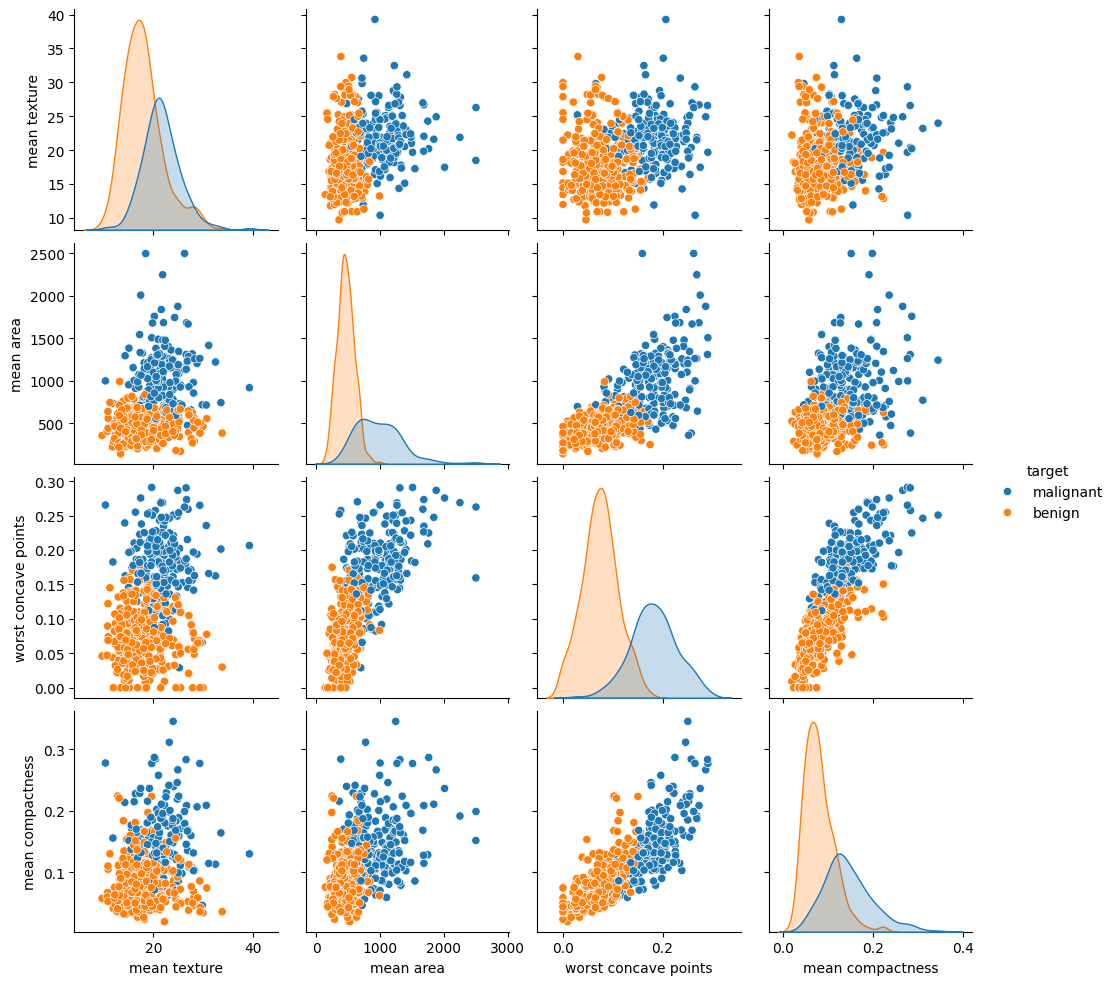

In [ ]:
wisconsin = load_breast_cancer()
X_cancer = wisconsin.data
y_cancer = wisconsin.target

df_cancer = pd.DataFrame(X_cancer, columns=wisconsin.feature_names)

# Add target column with string labels
df_cancer['target'] = pd.Series(y_cancer).map({0: 'malignant', 1: 'benign'})

# Subset of numeric features for pairplot
# subset_features = ['mean radius', 'mean perimeter', 'mean area', 'mean compactness/concavity']
subset_features_cancer = ['mean texture', 'mean area', 'worst concave points', 'mean compactness']

# Pairplot of raw data
sns.pairplot(df_cancer[subset_features_cancer + ['target']], hue='target')
plt.savefig(rf"{figpath}\Cancer_Pairplot.png")
plt.show()

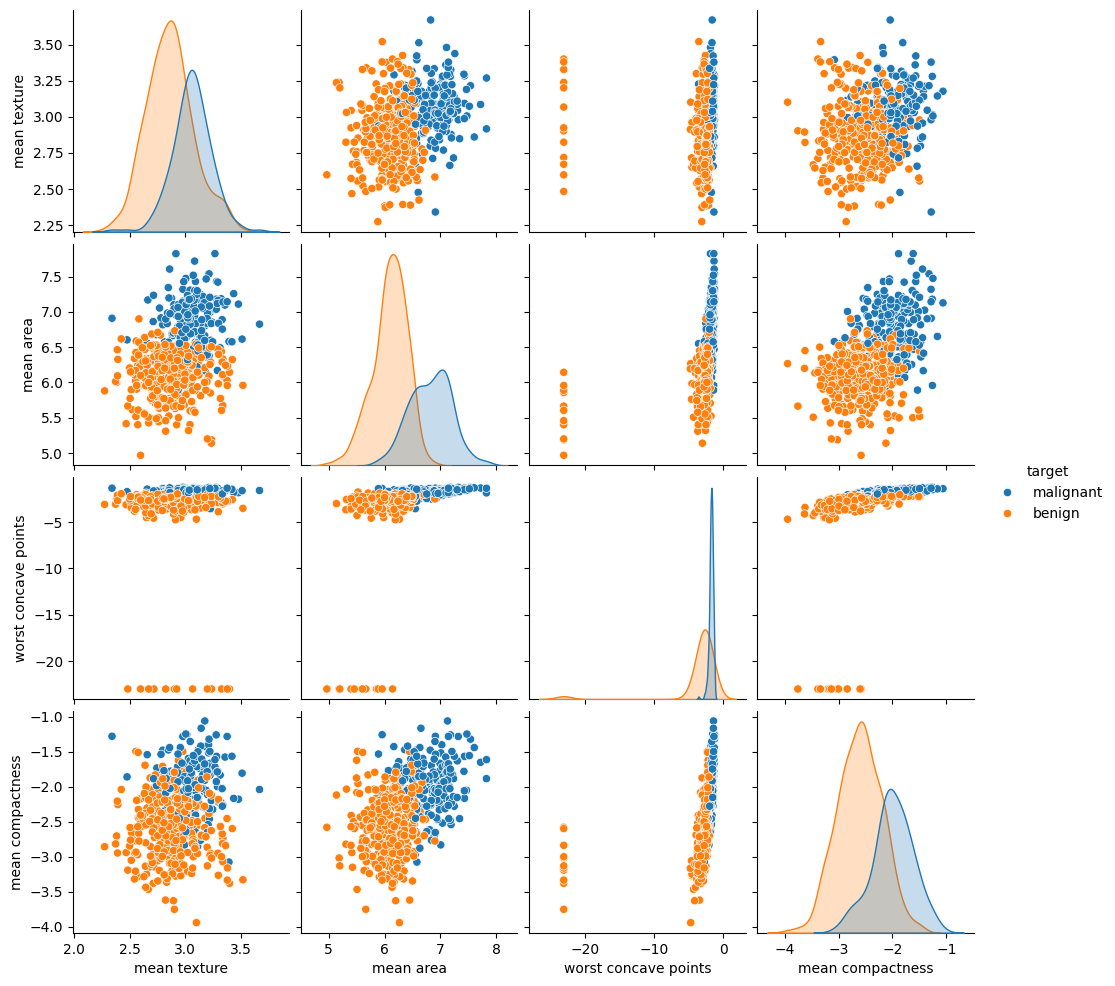

In [ ]:
# Log-transform ONLY numeric features
df_log_cancer = df_cancer.copy()
df_log_cancer[subset_features_cancer] = np.log(df_log_cancer[subset_features_cancer] + 1e-10)  # numeric only

# Target stays the same
df_log_cancer['target'] = df_cancer['target']

# Pairplot of log-transformed features
sns.pairplot(df_log_cancer[subset_features_cancer + ['target']], hue='target')
plt.savefig(rf"{figpath}\Cancer_Log_Pairplot.png")
plt.show()

selection of disciminative parameters such as shape and dimention. Smothness, and fractal dimension is not going to be helpfull. We could do a correlation matrix to see how these shape values are correlated. 

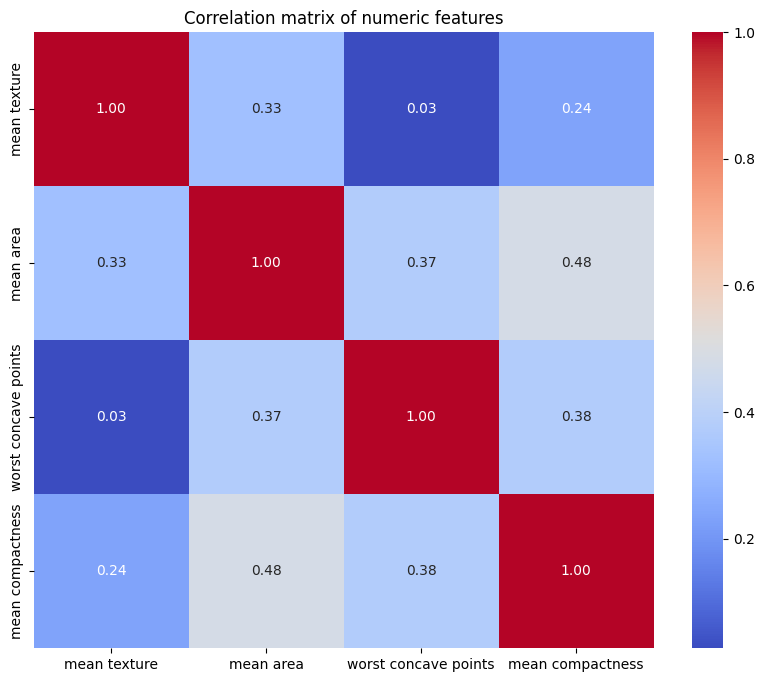

In [ ]:
corr_matrix = df_log_cancer[subset_features_cancer].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title("Correlation matrix of numeric features")
plt.savefig(rf"{figpath}\Cancer_CorrelationMatrix.png")
plt.show()

we selected features that are good for dicriminations, and are not too correlated, otherwise many of them will not be of use

=== Model Evaluation ===
Test Accuracy: 0.9441


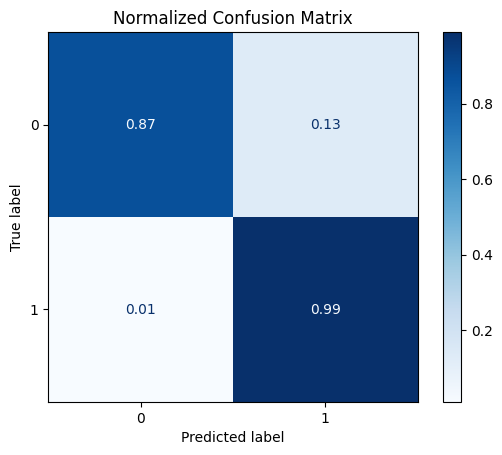

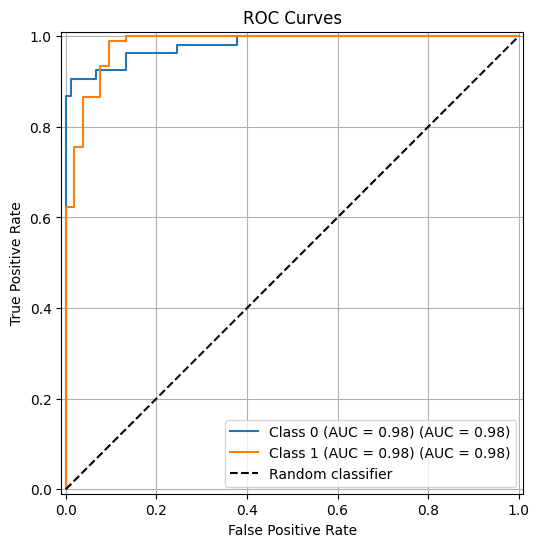

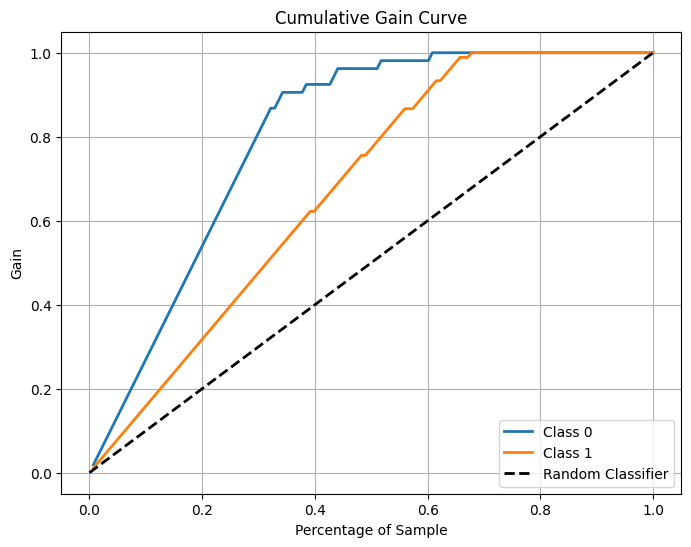

In [547]:
X_subset = df_log_cancer[subset_features_cancer].values  # numeric array
y_subset = y_cancer  # binary target
X_train, X_test, y_train, y_test = train_test_split(X_subset, y_subset, random_state=0)

model = YANNI(
    ProblemType='classification',
    network_architecture=[len(subset_features_cancer), 10, 8, 2],  # input=4, hidden layers 10+8, output=2
    activation_funcs=[ReLU_leaky, ReLU, softmax_stable],    # last layer softmax
    learning_rate=0.005,
    optimizer='adam',
    regularization='L1',
    lambdaVal=1e-6,
    momentum=0.9,
    batch_type='stochastic',
    max_iter=2000,
    max_epoch=500,
    tol=1e-4
)

# Train
model.train(X_train, y_train, verbose=True)

# Evaluate
model.evaluate_model(X_test, y_test)

max accuracy is around 0.92, with 0 = malignant, 1 = benine. we have 0.21 malignant predicted as benine.

# REGRESSION 

### part 1D Exploring: (adaptive optimizer, batch mode, Runge-sigma, Netowrk Architecture, no regularization)

In [87]:
def runge_function(N, noise=True, stdev=0.5):
    '''
    define runge function in the given interval with stochastic noise following N(0,sigma)
    sigma is a hardcoded value, 0.3 is recomended for the followign test cases.
    returns x and y vectors of size N
    '''
    x = np.linspace(-1, 1, N)
    y = 1/(1+25*x**2) 
    if noise:
        y += np.random.normal(0, stdev, size=N) 
    return x.reshape(-1,1), y.reshape(-1,1) # ensure column vectors

def pre_processing(x, y, test_ratio=0.2):
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_ratio, random_state=42)
    
    # Save unscaled versions for plotting
    x_train, x_test = X_train.copy(), X_test.copy()

    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Remove mean offset from y
    y_offset = np.mean(y_train, axis=0)
    y_train_scaled = y_train - y_offset
    
    # Maximal eigenvalue of Hessian (for learning rate heuristics)
    H = (2.0/X_train_scaled.shape[0]) * X_train_scaled.T @ X_train_scaled
    max_eig = np.max(np.linalg.eigvals(H))
    
    return X_train_scaled, X_test_scaled, x_train, x_test, y_train_scaled, y_offset, y_test, max_eig

In [99]:
# Generate Runge data
N = 1000
stdev=0.3
x, y = runge_function(N, noise=True, stdev=stdev)
X_train_scaled, X_test_scaled, x_train, x_test, y_train_scaled, y_offset, y_test, max_eig = pre_processing(x, y)

### test with ADAM, no regularization, batch mode, 2 hidden layers

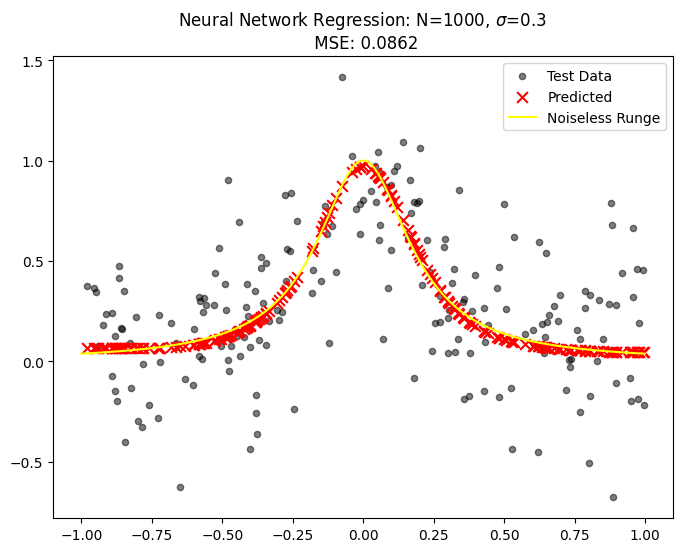

In [ ]:
# Build Neural Network
model = YANNI(
    ProblemType='regression',
    network_architecture=[1, 50, 100, 1],
    activation_funcs=[sigmoid, sigmoid, linear],  # linear output
    learning_rate=0.01,
    optimizer='adam',
    regularization=None,
    lambdaVal=0.0,
    batch_type='batch',  # full batch for regression
    max_iter=2000,
    max_epoch=500,
    tol=1e-5
)

# Train
model.train(X_train_scaled, y_train_scaled)

# Evaluate
y_pred_scaled = model.predict(X_test_scaled)
y_pred = y_pred_scaled + y_offset  # add offset back
# Compute MSE on test set
mse_test = np.mean((y_test - y_pred)**2)

plt.figure(figsize=(8, 6))
plt.scatter(x_test, y_test, label='Test Data', s=20, color='black',alpha=0.5)
plt.scatter(x_test, y_pred, label='Predicted', color='red', marker='x', s=60, alpha=1)

plot_xaxis2, plot_yaxis2 = runge_function(N, False)
x_gauss = np.linspace(-1, 1, 500)
sigma = 0.15
gaussian = np.exp(-x_gauss**2 / (2 * sigma**2))
plt.plot(plot_xaxis2, plot_yaxis2, label='Noiseless Runge', color='yellow')
# plt.plot(x_gauss, gaussian, label=rf'Gaussian $\sigma$={sigma}', color='cyan')

plt.title(f"Neural Network Regression: N={N}, $\sigma$={stdev} \n MSE: {mse_test:.4f}")
plt.legend()
plt.savefig(rf"{figpath}\Regression_N={N}_sigma={stdev}.png")
plt.show()

### test with ADAM, no regularization, batch mode, 1 hidden layer

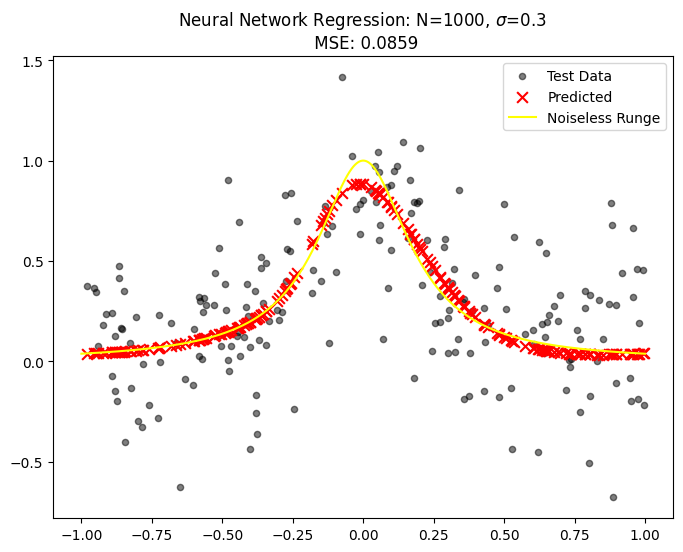

In [109]:
# Build Neural Network
model = YANNI(
    ProblemType='regression',
    network_architecture=[1, 50, 1],
    activation_funcs=[sigmoid, linear],  # linear output
    learning_rate=0.01,
    optimizer='adam',
    regularization=None,
    lambdaVal=0.0,
    batch_type='batch',  # full batch for regression
    max_iter=2000,
    max_epoch=500,
    tol=1e-5
)

# Train
model.train(X_train_scaled, y_train_scaled)

# Evaluate
y_pred_scaled = model.predict(X_test_scaled)
y_pred = y_pred_scaled + y_offset  # add offset back
# Compute MSE on test set
mse_test = np.mean((y_test - y_pred)**2)

plt.figure(figsize=(8, 6))
plt.scatter(x_test, y_test, label='Test Data', s=20, color='black',alpha=0.5)
plt.scatter(x_test, y_pred, label='Predicted', color='red', marker='x', s=60, alpha=1)

plot_xaxis2, plot_yaxis2 = runge_function(N, False)
x_gauss = np.linspace(-1, 1, 500)
sigma = 0.15
gaussian = np.exp(-x_gauss**2 / (2 * sigma**2))
plt.plot(plot_xaxis2, plot_yaxis2, label='Noiseless Runge', color='yellow')
# plt.plot(x_gauss, gaussian, label=rf'Gaussian $\sigma$={sigma}', color='cyan')

plt.title(f"Neural Network Regression: N={N}, $\sigma$={stdev} \n MSE: {mse_test:.4f}")
plt.legend()
plt.show()

with 1 layer the model captures still quite good, but not the center. 

### compare RMSProp/ADAM/VanillaGD, SDG/BATCH


-> Training model: Adam (Batch)

-> Training model: RMSProp (Batch)

-> Training model: Vanilla GD (Batch)

-> Training model: Adam (SGD)


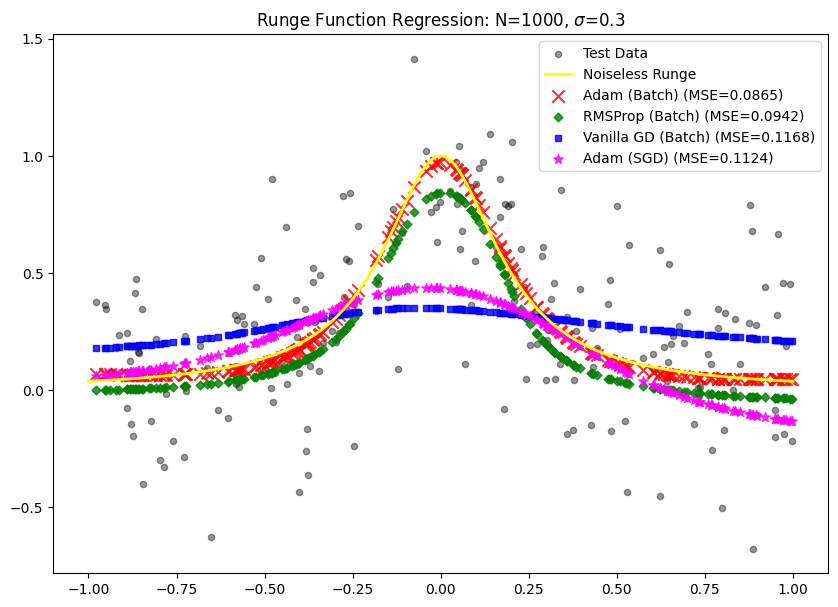

In [ ]:
configs = [
    ("Adam (Batch)", "adam", "batch"),
    ("RMSProp (Batch)", "rmsprop", "batch"),
    ("Vanilla GD (Batch)", "vanilla", "batch"),
    ("Adam (SGD)", "adam", "stochastic")
]

# --- Store results ---
results = {}

for label, opt, batch_type in configs:
    print(f"\n-> Training model: {label}")

    model = YANNI(
        ProblemType='regression',
        network_architecture=[1, 50, 100, 1],
        activation_funcs=[sigmoid, sigmoid, linear],
        learning_rate=0.01,
        optimizer=opt,
        regularization=None,
        lambdaVal=0.0,
        batch_type=batch_type,
        max_iter=2000,
        max_epoch=500,
        tol=1e-5
    )

    model.train(X_train_scaled, y_train_scaled)
    y_pred_scaled = model.predict(X_test_scaled)
    y_pred = y_pred_scaled + y_offset
    mse_test = np.mean((y_test - y_pred)**2)

    results[label] = (x_test, y_pred, mse_test)

# --- Plot Results ---
plt.figure(figsize=(10, 7))
plt.scatter(x_test, y_test, label='Test Data', color='black', s=20, alpha=0.4)

# True noiseless Runge
plot_xaxis2, plot_yaxis2 = runge_function(500, noise=False)
plt.plot(plot_xaxis2, plot_yaxis2, label='Noiseless Runge', color='yellow', linewidth=2)

# # Gaussian for comparison
# x_gauss = np.linspace(-1, 1, 500)
# sigma = 0.15
# gaussian = np.exp(-x_gauss**2 / (2 * sigma**2))
# plt.plot(x_gauss, gaussian, label=rf'Gaussian $\sigma$={sigma}', color='cyan', linestyle='--', linewidth=2)

# Add predictions
colors = ['red', 'green', 'blue', 'magenta']
markers = ['x', 'D', 's', '*']
sizes = [80, 20, 20, 50]
for (label, (x_test, y_pred, mse_val)), colour, marker, size in zip(results.items(), colors, markers, sizes):
    plt.scatter(x_test, y_pred, label=f'{label} (MSE={mse_val:.4f})', color=colour, marker=marker, s=size, alpha=0.8)

plt.title(fr"Runge Function Regression: N={N}, $\sigma$={stdev}")
plt.legend()
plt.show()

so rms prop is more square shaped around the center, leaving 0.001 meakes it collapse around center. So best fit will capture center and edges but fall too fast around mi9d range (gausian like). Relative performance is same for RMS and ADAM reflecting the adaptive method and parameter space itself. SGD and Vanilla GD are self explanatory.

### Testing 1D Runge with different Sigmas (best performing architecture/optimizer)

In [123]:
# Generate Runge data
N = 1000
stdev=0.5
x, y = runge_function(N, noise=True, stdev=stdev)
X_train_scaled, X_test_scaled, x_train, x_test, y_train_scaled, y_offset, y_test, max_eig = pre_processing(x, y)

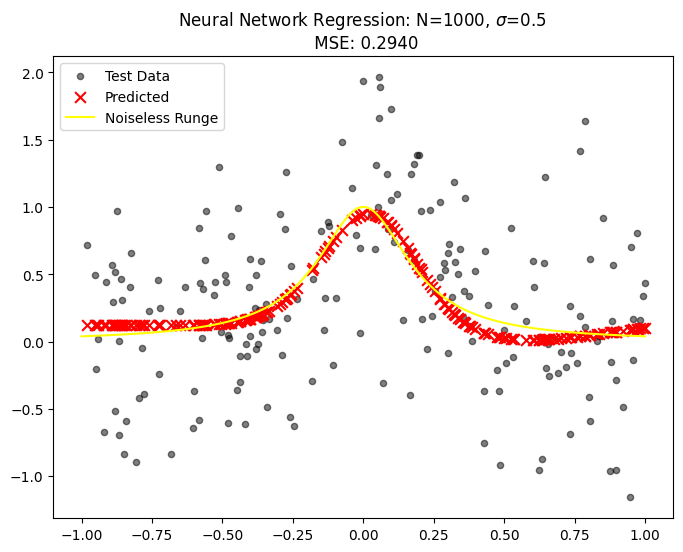

In [124]:
# Build Neural Network
model = YANNI(
    ProblemType='regression',
    network_architecture=[1, 50, 100, 1],
    activation_funcs=[sigmoid, sigmoid, linear],  # linear output
    learning_rate=0.01,
    optimizer='adam',
    regularization=None,
    lambdaVal=0.0,
    batch_type='batch',  # full batch for regression
    max_iter=2000,
    max_epoch=500,
    tol=1e-5
)

# Train
model.train(X_train_scaled, y_train_scaled)

# Evaluate
y_pred_scaled = model.predict(X_test_scaled)
y_pred = y_pred_scaled + y_offset  # add offset back
# Compute MSE on test set
mse_test = np.mean((y_test - y_pred)**2)

plt.figure(figsize=(8, 6))
plt.scatter(x_test, y_test, label='Test Data', s=20, color='black',alpha=0.5)
plt.scatter(x_test, y_pred, label='Predicted', color='red', marker='x', s=60, alpha=1)

plot_xaxis2, plot_yaxis2 = runge_function(N, False)
x_gauss = np.linspace(-1, 1, 500)
sigma = 0.15
gaussian = np.exp(-x_gauss**2 / (2 * sigma**2))
plt.plot(plot_xaxis2, plot_yaxis2, label='Noiseless Runge', color='yellow')
# plt.plot(x_gauss, gaussian, label=rf'Gaussian $\sigma$={sigma}', color='cyan')

plt.title(f"Neural Network Regression: N={N}, $\sigma$={stdev} \n MSE: {mse_test:.4f}")
plt.legend()
plt.show()

In [133]:
# Generate Runge data
N = 1000
stdev=1
x, y = runge_function(N, noise=True, stdev=stdev)
X_train_scaled, X_test_scaled, x_train, x_test, y_train_scaled, y_offset, y_test, max_eig = pre_processing(x, y)

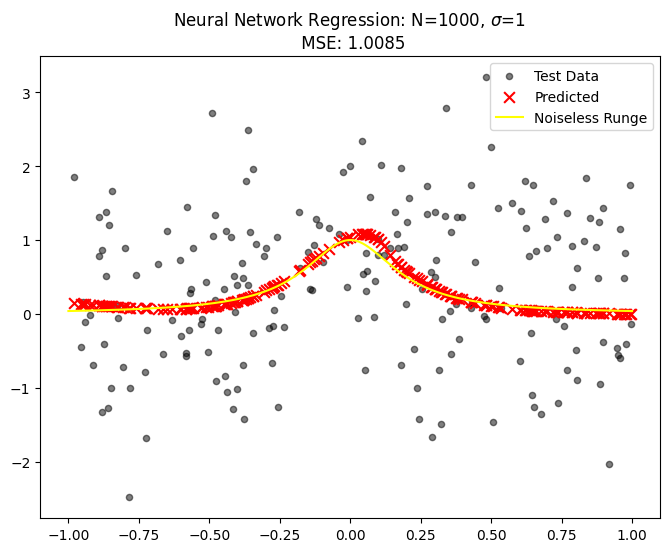

In [134]:
# Build Neural Network
model = YANNI(
    ProblemType='regression',
    network_architecture=[1, 50, 100, 1],
    activation_funcs=[sigmoid, sigmoid, linear],  # linear output
    learning_rate=0.01,
    optimizer='adam',
    regularization=None,
    lambdaVal=0.0,
    batch_type='batch',  # full batch for regression
    max_iter=2000,
    max_epoch=500,
    tol=1e-5
)

# Train
model.train(X_train_scaled, y_train_scaled)

# Evaluate
y_pred_scaled = model.predict(X_test_scaled)
y_pred = y_pred_scaled + y_offset  # add offset back
# Compute MSE on test set
mse_test = np.mean((y_test - y_pred)**2)

plt.figure(figsize=(8, 6))
plt.scatter(x_test, y_test, label='Test Data', s=20, color='black',alpha=0.5)
plt.scatter(x_test, y_pred, label='Predicted', color='red', marker='x', s=60, alpha=1)

plot_xaxis2, plot_yaxis2 = runge_function(N, False)
x_gauss = np.linspace(-1, 1, 500)
sigma = 0.15
gaussian = np.exp(-x_gauss**2 / (2 * sigma**2))
plt.plot(plot_xaxis2, plot_yaxis2, label='Noiseless Runge', color='yellow')
# plt.plot(x_gauss, gaussian, label=rf'Gaussian $\sigma$={sigma}', color='cyan')

plt.title(f"Neural Network Regression: N={N}, $\sigma$={stdev} \n MSE: {mse_test:.4f}")
plt.legend()
plt.show()

the fit worsens but for larer noise, but the shape is still traced well (except most notisably around the center). The shark fin phenomenon, **a drift away from data density**. Adding more layers is not solving the problem nor adding more nodes. Using 1 hidden layer with 50 will collapse sligtly around center. But it will always be much worse or slightly worse. SPecially with fewer nodes than 50. 

### 2D $R(x,y)$ Stress Testing best perofming optimizer with regularization (L2/L1) for $\sigma_R \in$ (0.1, 0.3, 0.5) 

### test: Architecture (layers, nodes, activation functions)



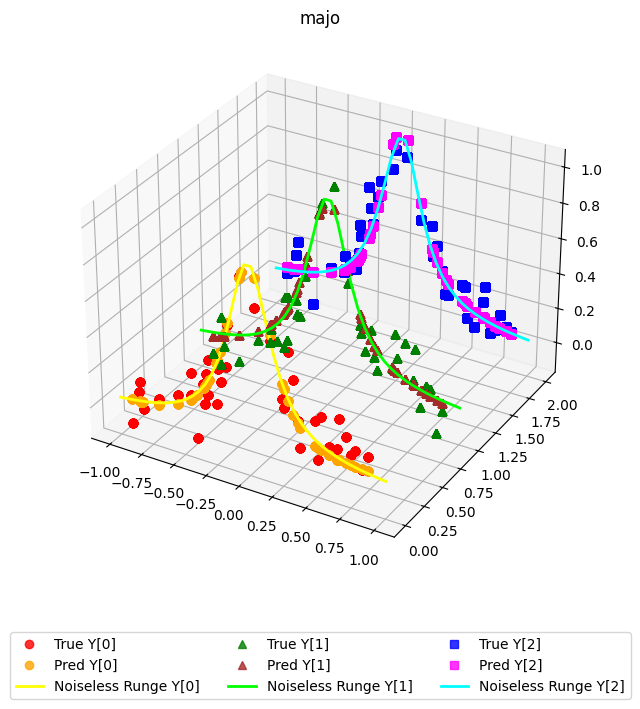

In [ ]:
N = 200
stdev=0.1
x, _ = runge_function(N, noise=False, stdev=stdev)  
_, y1 = runge_function(N, noise=True, stdev=stdev)  
_, y2 = runge_function(N, noise=True, stdev=stdev)  
_, y3 = runge_function(N, noise=True, stdev=stdev)
Y = np.hstack([y1, y2, y3])          # shape (N,3)

X_train_scaled, X_test_scaled, x_train, x_test, Y_train_scaled, Y_offset, Y_test, max_eig = pre_processing(x, Y)   #np.asarray(x).reshape(-1, 1)

model = YANNI(
    ProblemType='regression',
    network_architecture=[1, 50, 100, 3],
    activation_funcs=[sigmoid, sigmoid, linear],
    learning_rate=0.01,
    optimizer='adam',
    batch_type='batch',
    max_iter=2000,
    max_epoch=500,
    tol=1e-5
)
model.train(X_train_scaled, Y_train_scaled)
Y_pred_scaled = model.predict(X_test_scaled)
Y_pred = Y_pred_scaled + Y_offset 

markers = ['o', '^', 's']
colors_true = ['red', 'green', 'blue']
colors_pred = ['orange', 'brown', 'magenta']
colors_runge = ['yellow', 'lime', 'cyan']  # colors for true Runge functions

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot each component
for i in range(3):
    # True and predicted points
    ax.plot(x_test.ravel(), i*np.ones_like(x_test), Y_test[:, i],
            linestyle='None', marker=markers[i], alpha=0.8,
            label=f'True Y[{i}]', color=colors_true[i])
    ax.plot(x_test.ravel(), i*np.ones_like(x_test), Y_pred[:, i],
            linestyle='None', marker=markers[i], alpha=0.8,
            label=f'Pred Y[{i}]', color=colors_pred[i])
    
    # Overlay noiseless Runge curve for this component
    plot_xaxis2, plot_yaxis2 = runge_function(len(x_test), False)
    # Slight offset for 3D visualization (y = i)
    ax.plot(plot_xaxis2, i*np.ones_like(plot_xaxis2), plot_yaxis2,
            color=colors_runge[i], linewidth=2, label=f'Noiseless Runge Y[{i}]')
ax.set_title('majo')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3, fontsize=10)
plt.show()

In [207]:
def runge_function_2d(N, noise=True, stdev=0.5):
    '''
    Define 2D Runge function for proper 3D surface plotting
    '''
    grid_size = int(np.sqrt(N))
    x1 = np.linspace(-1, 1, grid_size)
    x2 = np.linspace(-1, 1, grid_size)
    X1, X2 = np.meshgrid(x1, x2)
    # 2D Runge function: 1/(1 + 25*(x1^2 + x2^2))
    y = 1/(1 + 25*(X1**2 + X2**2))
    if noise:
        y += np.random.normal(0, stdev, size=y.shape)
    return np.column_stack([X1.ravel(), X2.ravel()]), y.ravel()

# Generate 2D data
N = 256  # Perfect square for meshgrid
x_2d, y_true = runge_function_2d(N, noise=False, stdev=0)
test_stdevs = [0.1, 0.3, 0.5]

# Generate multiple noisy outputs, with Uncorrelated noise
_, y1 = runge_function_2d(N, noise=True, stdev=test_stdevs[0])
_, y2 = runge_function_2d(N, noise=True, stdev=test_stdevs[1])  
_, y3 = runge_function_2d(N, noise=True, stdev=test_stdevs[2])
Y_2d = np.column_stack([y1, y2, y3])
# x_2d(N,2), Y_2d(N,3)

# Save the grid stucture before preprocessing with train test split
grid_size = int(np.sqrt(N))
X1_original = x_2d[:, 0].reshape(grid_size, grid_size)
X2_original = x_2d[:, 1].reshape(grid_size, grid_size)

# Train test split
X_train, X_test, Y_train, Y_test = train_test_split(x_2d, Y_2d, test_size=0.2, random_state=42)

# New preprocessing: standard scaling, offset separation but for 2d meshgrid
x_scaler = StandardScaler()
X_train_scaled = x_scaler.fit_transform(X_train)  
X_test_scaled = x_scaler.transform(X_test)        

y_scaler = StandardScaler()
Y_train_scaled = y_scaler.fit_transform(Y_train)  
Y_test_scaled = y_scaler.transform(Y_test)        

# Store scaling parameters for later
Y_offset = y_scaler.mean_
Y_scale = y_scaler.scale_

### 2 hidden layers, sigmoids adam, without regression

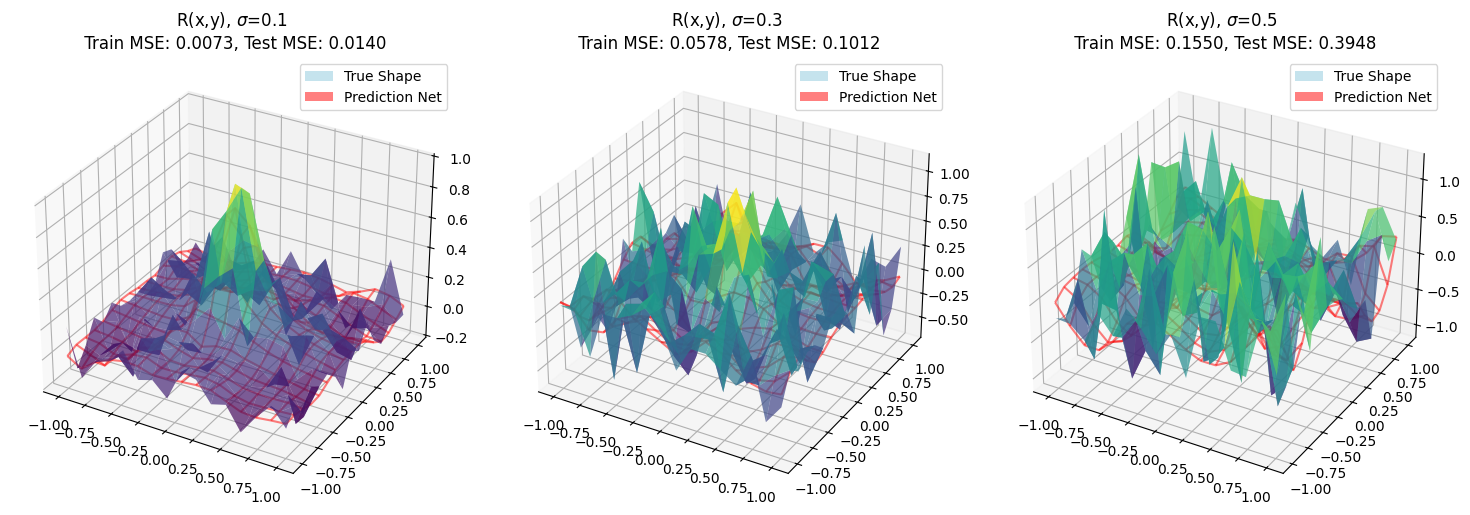

In [210]:
model = YANNI(
    ProblemType='regression',
    network_architecture=[2, 50, 100, 3],
    activation_funcs=[sigmoid, sigmoid, linear],
    learning_rate=0.01,
    optimizer='adam',
    batch_type='batch',
    max_iter=2000,
    max_epoch=500,
    tol=1e-5
)
model.train(X_train_scaled, Y_train_scaled)

# Predict on all scaled data
Y_train_pred_scaled = model.predict(X_train_scaled)
Y_test_pred_scaled = model.predict(X_test_scaled)
Y_train_pred = Y_train_pred_scaled * Y_scale + Y_offset
Y_test_pred = Y_test_pred_scaled * Y_scale + Y_offset

# Evaluate OVERFIT using MSE TRAIN/TEST
train_mse = []
test_mse = []
for i in range(3):
    train_mse.append(mean_squared_error(Y_train[:, i], Y_train_pred[:, i]))
    test_mse.append(mean_squared_error(Y_test[:, i], Y_test_pred[:, i]))

# Vaisalize THE FULL TRAIN+TEST data (because of grid)

X_full_scaled = x_scaler.transform(x_2d)  
Y_full_pred_scaled = model.predict(X_full_scaled)
Y_full_pred = Y_full_pred_scaled * Y_scale + Y_offset

fig = plt.figure(figsize=(15, 5))
for i in range(3):
    ax = fig.add_subplot(1, 3, i+1, projection='3d')
    
    # Reshape to grid
    Y_true_surface = Y_2d[:, i].reshape(grid_size, grid_size)
    Y_pred_surface = Y_full_pred[:, i].reshape(grid_size, grid_size)
    
    # Plot true surface
    surf_true = ax.plot_surface(X1_original, X2_original, Y_true_surface, alpha=0.7, cmap='viridis', label='True')
    
    # Plot predicted surface as Fish Net
    surf_pred = ax.plot_wireframe(X1_original, X2_original, Y_pred_surface, color='red', alpha=0.5, label='Predicted')
    
    ax.set_title(f'R(x,y), $\sigma$={test_stdevs[i]} \n Train MSE: {train_mse[i]:.4f}, Test MSE: {test_mse[i]:.4f}')
    
    # Create proxy artists for legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='lightblue', alpha=0.7, label='True Shape'),
        Patch(facecolor='red', alpha=0.5, label='Prediction Net')
    ]
    ax.legend(handles=legend_elements)

plt.tight_layout()
plt.show()

### adam, L2, deeper network

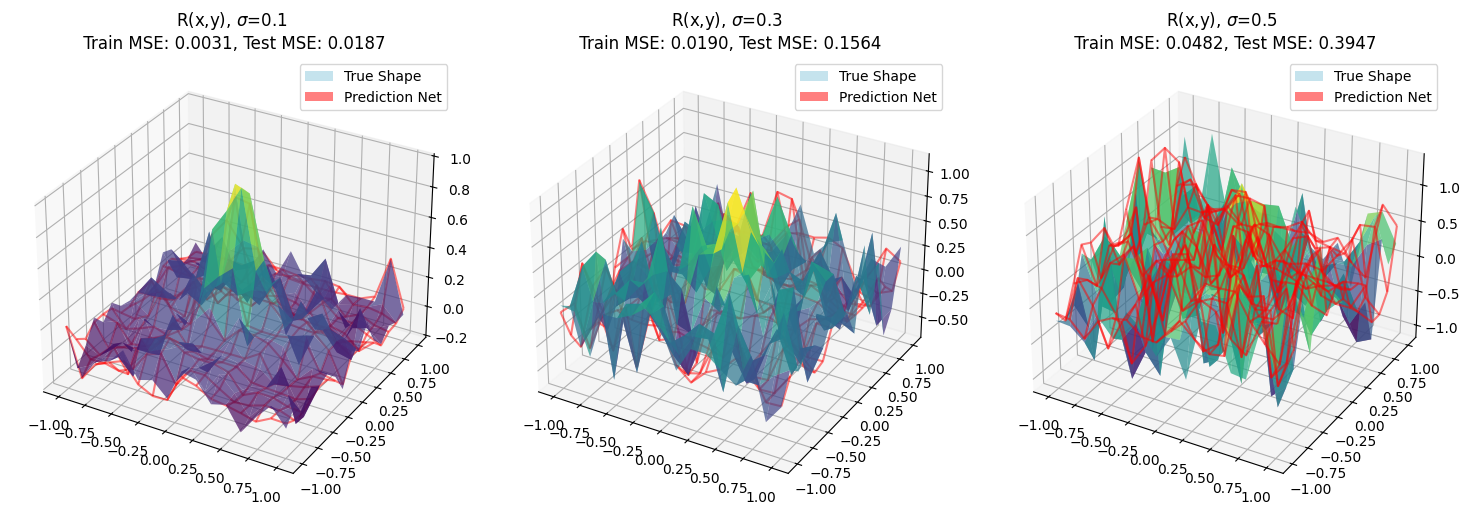

In [211]:
model = YANNI(
    ProblemType='regression',
    network_architecture=[2, 100, 150, 100, 3],   # deeper network 
    activation_funcs=[sigmoid, sigmoid, sigmoid, linear],
    learning_rate=0.05,   #0.01
    optimizer='adam',
    batch_type='batch',
    max_iter=3000,   #2000
    max_epoch=800,   #500
    tol=1e-5,
    regularization='L2',
    lambdaVal=1e-5
)
model.train(X_train_scaled, Y_train_scaled)

# Predict on all scaled data
Y_train_pred_scaled = model.predict(X_train_scaled)
Y_test_pred_scaled = model.predict(X_test_scaled)
Y_train_pred = Y_train_pred_scaled * Y_scale + Y_offset
Y_test_pred = Y_test_pred_scaled * Y_scale + Y_offset

# Evaluate OVERFIT using MSE TRAIN/TEST
train_mse = []
test_mse = []
for i in range(3):
    train_mse.append(mean_squared_error(Y_train[:, i], Y_train_pred[:, i]))
    test_mse.append(mean_squared_error(Y_test[:, i], Y_test_pred[:, i]))

# Vaisalize THE FULL TRAIN+TEST data (because of grid)

X_full_scaled = x_scaler.transform(x_2d)  
Y_full_pred_scaled = model.predict(X_full_scaled)
Y_full_pred = Y_full_pred_scaled * Y_scale + Y_offset

fig = plt.figure(figsize=(15, 5))
for i in range(3):
    ax = fig.add_subplot(1, 3, i+1, projection='3d')
    
    # Reshape to grid
    Y_true_surface = Y_2d[:, i].reshape(grid_size, grid_size)
    Y_pred_surface = Y_full_pred[:, i].reshape(grid_size, grid_size)
    
    # Plot true surface
    surf_true = ax.plot_surface(X1_original, X2_original, Y_true_surface, alpha=0.7, cmap='viridis', label='True')
    
    # Plot predicted surface as Fish Net
    surf_pred = ax.plot_wireframe(X1_original, X2_original, Y_pred_surface, color='red', alpha=0.5, label='Predicted')
    
    ax.set_title(f'R(x,y), $\sigma$={test_stdevs[i]} \n Train MSE: {train_mse[i]:.4f}, Test MSE: {test_mse[i]:.4f}')
    
    # Create proxy artists for legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='lightblue', alpha=0.7, label='True Shape'),
        Patch(facecolor='red', alpha=0.5, label='Prediction Net')
    ]
    ax.legend(handles=legend_elements)

plt.tight_layout()
plt.show()

### wider netowork (not too good)

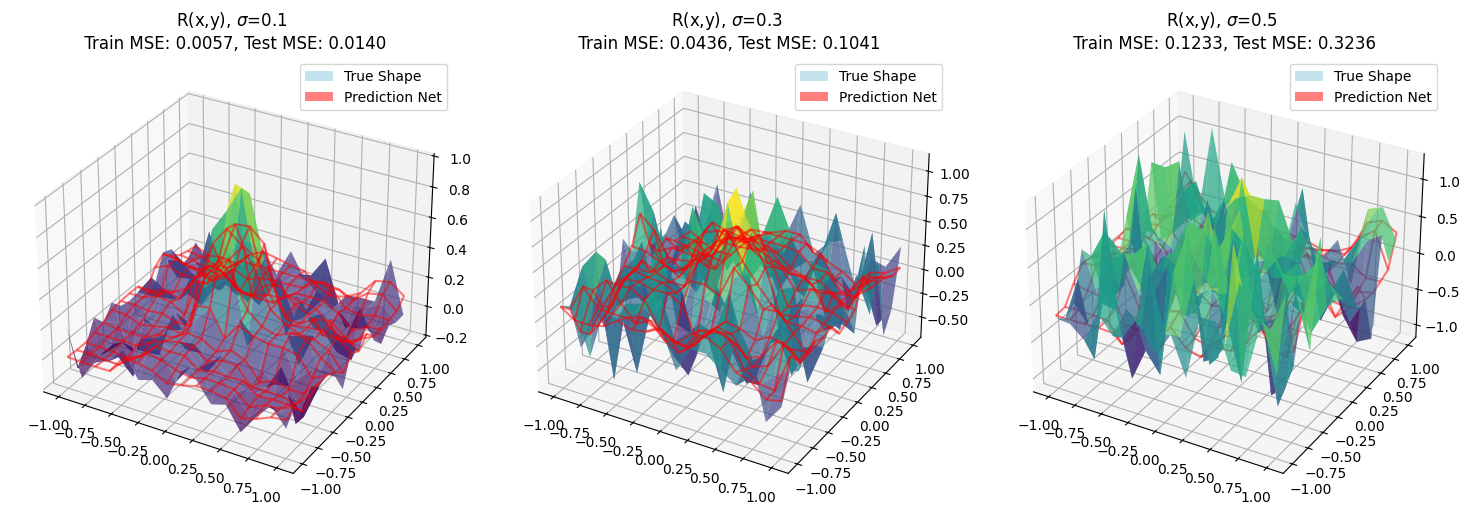

In [212]:
model = YANNI(
    ProblemType='regression',
    network_architecture=[2, 300, 300, 3],   # deeper network 
    activation_funcs=[sigmoid, sigmoid, linear],
    learning_rate=0.05,   #0.01
    optimizer='adam',
    batch_type='batch',
    max_iter=3000,   #2000
    max_epoch=800,   #500
    tol=1e-5,
    regularization='L2',
    lambdaVal=1e-5
)
model.train(X_train_scaled, Y_train_scaled)

# Predict on all scaled data
Y_train_pred_scaled = model.predict(X_train_scaled)
Y_test_pred_scaled = model.predict(X_test_scaled)
Y_train_pred = Y_train_pred_scaled * Y_scale + Y_offset
Y_test_pred = Y_test_pred_scaled * Y_scale + Y_offset

# Evaluate OVERFIT using MSE TRAIN/TEST
train_mse = []
test_mse = []
for i in range(3):
    train_mse.append(mean_squared_error(Y_train[:, i], Y_train_pred[:, i]))
    test_mse.append(mean_squared_error(Y_test[:, i], Y_test_pred[:, i]))

# Vaisalize THE FULL TRAIN+TEST data (because of grid)

X_full_scaled = x_scaler.transform(x_2d)  
Y_full_pred_scaled = model.predict(X_full_scaled)
Y_full_pred = Y_full_pred_scaled * Y_scale + Y_offset

fig = plt.figure(figsize=(15, 5))
for i in range(3):
    ax = fig.add_subplot(1, 3, i+1, projection='3d')
    
    # Reshape to grid
    Y_true_surface = Y_2d[:, i].reshape(grid_size, grid_size)
    Y_pred_surface = Y_full_pred[:, i].reshape(grid_size, grid_size)
    
    # Plot true surface
    surf_true = ax.plot_surface(X1_original, X2_original, Y_true_surface, alpha=0.7, cmap='viridis', label='True')
    
    # Plot predicted surface as Fish Net
    surf_pred = ax.plot_wireframe(X1_original, X2_original, Y_pred_surface, color='red', alpha=0.5, label='Predicted')
    
    ax.set_title(f'R(x,y), $\sigma$={test_stdevs[i]} \n Train MSE: {train_mse[i]:.4f}, Test MSE: {test_mse[i]:.4f}')
    
    # Create proxy artists for legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='lightblue', alpha=0.7, label='True Shape'),
        Patch(facecolor='red', alpha=0.5, label='Prediction Net')
    ]
    ax.legend(handles=legend_elements)

plt.tight_layout()
plt.show()

### ========================================================================================
### Mason-Dixon Line
### ========================================================================================

### test 1D with differen N sizes, with architecture heatmap and hypter parameter heatmap

### part B Classifcation(lambda, eta. width, depth)

### part D: The other function 2D 

### part C Standard Libraries

### sacale the classification features

### correlated disciminative vartianbles: use regularization?